## 9. GLMのベイズモデル化と事後分布の推定
### 9.1 種子数のポアソン回帰(個体差なし)


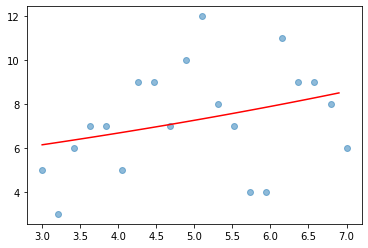

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np
from scipy.stats import binom

d = pd.read_csv('C:/Users/tanak/study/参考書/データ解析のための統計モデリング/kubobook_2012/gibbs/data.csv')

# 応答変数は(生存数, 死亡数)であり、I()を使って表現
model = smf.glm(formula='y ~ x', data=d, family=sm.families.Poisson())
results = model.fit()
# results.summary()

pred = lambda x: results.params[0] + results.params[1] * x

x = np.arange(3, 7, 0.1)

plt.scatter(d.x, d.y, alpha=.5)
plt.plot(x, np.exp(pred(x)), 'red')

### 9.2 GLMのベイズモデル化
個体$i$の種子数$y_i$のばらつきを平均$\lambda_i$のポアソン分布$p(y_i|\lambda_i)$に従うとする。  
線形予測子と対数リンク関数を使って、この平均を$\lambda_i=\exp{\beta_1+\beta_2x_i}$と指定する。  
このモデルの尤度関数$L(\beta_1,\beta_2)$は、
$$
L(\beta_1,\beta_2)=\prod_{i}p(y_i|\lambda_i)=\prod_{i}p(y_i|\beta_1,\beta_2,x_i)
$$
となる。($\boldsymbol{X}=\{x_i\}$)  
パラメータ$\{\beta_1,\beta_2\}$がある値をとるときに$\boldsymbol{Y}$が得られる確率は$p(\boldsymbol{Y}|\beta_1,\beta_2)=L(\beta_1,\beta_2)$となる。  
ベイズモデルの事後分布は(尤度)×(事前分布)に比例するので、
$$
p(\beta_1,\beta_2|\boldsymbol{Y})\propto p(\boldsymbol{Y}|\beta_1,\beta_2)p(\beta_1)p(\beta_2)
$$


### 9.3 無情報事前分布
GLMのパラメータ$\beta_*$の事前分布の決め方について考える。  
事前分布は「観測データ$\boldsymbol{Y}$が得られていないときのパラメータ$\beta_*$の確率分布」などと定義されるが、  
今回は架空植物のデータであるため確率分布はわからない。  
そこで、線形予測子のパラメータ$\beta_*$の値は$[-\infty,+\infty]$の範囲で好きな値をとっていいといったことを表現する事前分布を設定する。  
このような事前分布は**無情報事前分布**と呼ぶ。  
この無情報事前分布として以下の2種類の確率分布がよく使われる。  
- たとえば、$-10^9<\beta_*<10^9$の範囲をとる一様分布  
- 平均ゼロで標準偏差がとても大きい「ひらべったい正規分布」

ここでは「ひらべったい正規分布」を使うことにする。

### 9.4 ベイズ統計モデルの事後分布の推定
切片$\beta_1$と傾き$\beta_2$の事後分布$p(\beta_1,\beta_2|\boldsymbol{Y})$をMCMCサンプリングを使って推定する。

<ipython-input-39-e1c983c306f3>:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1600,
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta2]
>Metropolis: [beta1]


Sampling 4 chains for 100 tune and 1_600 draw iterations (400 + 6_400 draws total) took 104 seconds.
The number of effective samples is smaller than 10% for some parameters.
<ipython-input-39-e1c983c306f3>:19: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace) # サンプリング過程を表示する
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\tanak\anaconda3\envs\tanaka_env1\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in trans

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta1,1.980,0.082,1.814,2.121,0.004,0.003,486.0,293.0,1.01
beta2,0.084,0.069,-0.054,0.197,0.004,0.003,354.0,339.0,1.02


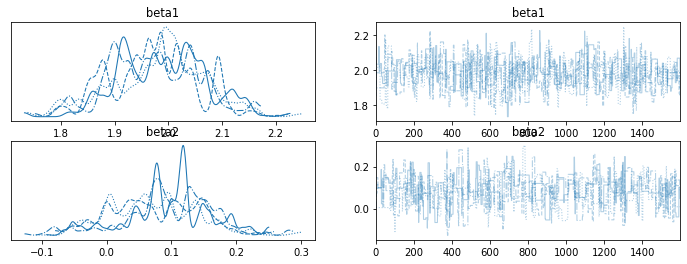

In [39]:
import pymc3 as pm

with pm.Model() as model:
    beta1 = pm.Normal('beta1', mu=0, sd=100)
    beta2 = pm.Normal('beta2', mu=0, sd=100)
    
    theta = beta1 + beta2*(d['x'].values - np.mean(d['x'].values))
    
    y = pm.Poisson('y', mu=np.exp(theta), observed=d['y'].values)

# サンプリングして推定する
with model: # Metropolis, HamiltonianMC
    trace = pm.sample(1600,
                      step=pm.Metropolis(),
                      tune=100, # 最初の100ステップは捨てる
                      random_seed=0)

# 得られた結果を確認する
pm.traceplot(trace) # サンプリング過程を表示する
pm.summary(trace) # 推定結果を表示する

### 6.5 MCMCサンプルから事後分布を推定
合計6400サンプルから推定された、$\beta_1$と$\beta_2$の**周辺事後分布**は図のようになる。  
同時分布である事後分布$p(\beta_1,\beta_2|\boldsymbol{Y})$において、$\beta_2$で積分すると$\beta_1$の周辺事後分布
$$
p(\beta_1|\boldsymbol{Y})=\int p(\beta_1,\beta_2|\boldsymbol{Y})d\beta_2
$$
が得られる。

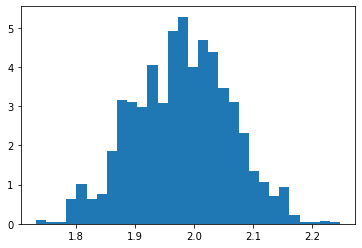

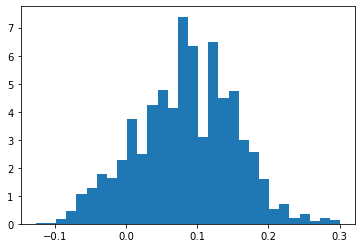

In [85]:
plt.hist(trace.beta1, bins=30, density=True);
plt.show()
plt.hist(trace.beta2, bins=30, density=True);

サンプルされたうち一部の$\{\beta_1,\beta_2\}$を使って、平均種子数$\lambda$を予測させると次の上図になる。  
また、事後分布$p(\beta_1,\beta_2|\boldsymbol{Y})$は下図のようになる。  
$\{\beta_1,\beta_2\}$のMCMCサンプル間には強い相関がないことが分かる。

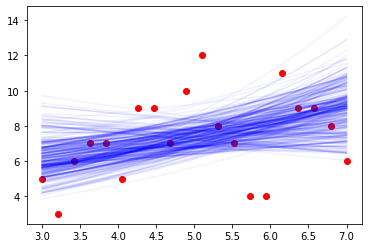

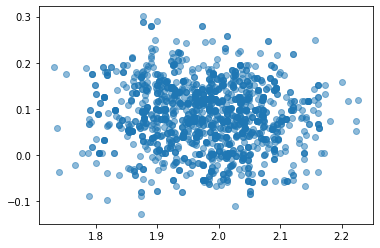

In [68]:
for i in range(400):
    plt.plot(d['x'], np.exp(trace.beta1[i*4]+(d['x']-np.mean(d['x']))*trace.beta2[i*4]), alpha=.05, color='blue');
plt.scatter(d['x'], d['y'], color='red');
plt.show()

plt.scatter(trace.beta1[::4], trace.beta2[::4], alpha=.5);

### 9.6 複数パラメーターのMCMCサンプリング
MCMCサンプリングは値を少しずつ変更していく方式であるが、複数のパラメーターを同時に変更していくのは簡単ではない。  
そこで、$\beta_1$と$\beta_2$の値を交互に更新する方法を使う。  
- いったん$\beta_2$を定数だとみなして$\beta_1$を変更
- 変更された$\beta_1$を定数だとみなして$\beta_2$を変更

という操作を繰り返すことによって、$p(\beta_1,\beta_2|\boldsymbol{Y})$からのランダムサンプリングを発生させる方法である。  
  
#### ギブスサンプリング
ギブスサンプリングは、新しい値の確率分布を作り、その確率分布のランダムサンプルを新しい値をとる方式である。  
新しい確率分布とは、多変量確率分布からひとつの変量をのぞいて、他の変量をすべてを定数とする一変量確率分布である。  
これを**全条件つき分布**と呼ぶ。  
ギブスサンプリングの手順は次のようになる。
1. 最初に何らかの$\{\beta_1, \beta_2\}$の初期値を設定しておく
2. $p(\beta_1|\boldsymbol{Y}, \beta_2)$にしたがう乱数を発生させて、それを新しい$\beta_1$とする
3. $p(\beta_2|\boldsymbol{Y}, \beta_1)$にしたがう乱数を発生させて、それを新しい$\beta_2$とする
4. このMCMCステップにおける$\beta_1$と$\beta_2$を記録しておく
5. 十分な個数の$\beta_1$と$\beta_2$のサンプルが得られるまで、2-4を繰り返す

In [206]:
import warnings

warnings.simplefilter('ignore')

def gibbs(beta1=None, beta2=None):
    with pm.Model() as model:
        if beta1 is None:
            beta1 = pm.Normal('beta1', mu=b1_selected[-1], sd=100)
            c = 0
        if beta2 is None:
            beta2 = pm.Normal('beta2', mu=b2_selected[-1], sd=100)
            c = 1
        
        theta = beta1 + beta2*(d['x'].values - np.mean(d['x'].values))
    
        y = pm.Poisson('y', mu=np.exp(theta), observed=d['y'].values)

    # サンプリングして推定する
    with model: # Metropolis, HamiltonianMC
        trace = pm.sample(1500,
                          step=pm.Metropolis(),
                          tune=100, # 最初の100ステップは捨てる
                          progressbar=False,
                          random_seed=0)

    if c==0:
        print()
        return np.random.choice(np.round(trace.beta1, 3)), trace.beta1
    else:
        return np.random.choice(np.round(trace.beta2, 3)), trace.beta2

In [205]:
b1_selected = [1.5]
b2_selected = [0]

b1_samples = []
b2_samples = []
b2_next = 0

for i in range(5):
    print(b2_next)
    b1_next, b1_sample = gibbs(beta1=None, beta2=b2_next)
    b1_samples.append(b1_sample)
    b1_selected.append(b1_next)
    
    print(b1_next)
    b2_next, b2_sample = gibbs(beta1=b1_next, beta2=None)
    b2_samples.append(b2_sample)
    b2_selected.append(b2_next)

0


Only 160 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [beta1]
Sampling 4 chains for 100 tune and 160 draw iterations (400 + 640 draws total) took 33 seconds.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.



1.996


Only 160 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [beta2]
Sampling 4 chains for 100 tune and 160 draw iterations (400 + 640 draws total) took 36 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


0.071


Only 160 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [beta1]
Sampling 4 chains for 100 tune and 160 draw iterations (400 + 640 draws total) took 34 seconds.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.



1.954


Only 160 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [beta2]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\tanak\anaconda3\envs\tanaka_env1\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-205-66c1e1fd6edf>", line 15, in <module>
    b2_next, b2_sample = gibbs(beta1=b1_next, beta2=None)
  File "<ipython-input-204-4f5d2ec62d55>", line 20, in gibbs
    trace = pm.sample(160,
  File "C:\Users\tanak\anaconda3\envs\tanaka_env1\lib\site-packages\pymc3\sampling.py", line 559, in sample
    trace = _mp_sample(**sample_args, **parallel_args)
  File "C:\Users\tanak\anaconda3\envs\tanaka_env1\lib\site-packages\pymc3\sampling.py", line 1461, in _mp_sample
    sampler = ps.ParallelSampler(
  File "C:\Users\tanak\anaconda3\envs\tanaka_env1\lib\site-packages\pymc3\parallel_sampling.py", line 431, in __init__
    self._samplers = [
  File "C:\Users\tanak\anaconda3\envs\tanaka_env1\lib\site-packages\pymc3\parallel_sampling.py", line 432, in <listcomp>
  

TypeError: object of type 'NoneType' has no len()

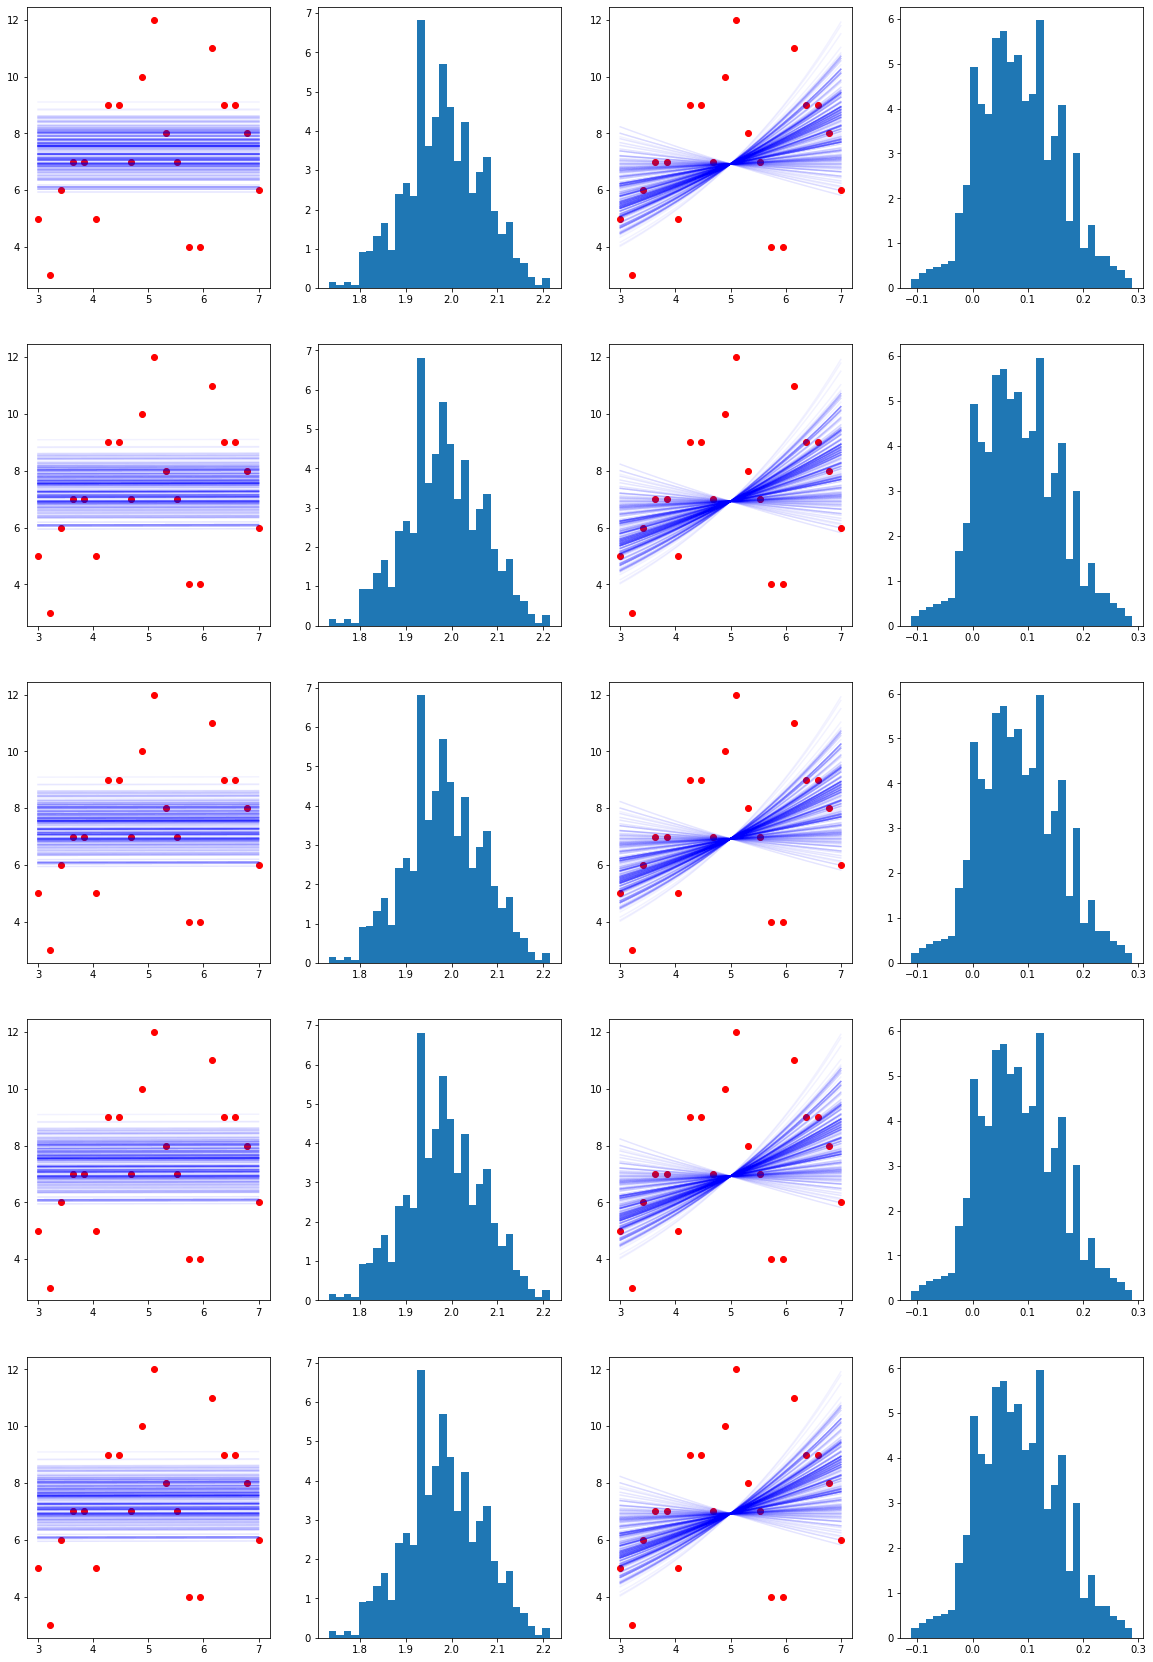

In [150]:
fig ,axes = plt.subplots(nrows=5, ncols=4, figsize=(5*4, 3*10))

for j in np.arange(5):
    for i in range(400):
        axes[j][0].plot(d['x'], np.exp(b1_samples[j][i*4])*np.ones(len(d)) + (d['x']-np.mean(d['x']))*b2_selected[j], alpha=.05, color='blue');
    axes[j][0].scatter(d['x'], d['y'], color='red');

    axes[j][1].hist(b1_samples[j], bins=30, density=True);
    
    for i in range(400):
        axes[j][2].plot(d['x'], np.exp(b1_selected[j] + (d['x']-np.mean(d['x']))*b2_samples[j][i*4]), alpha=.05, color='blue');
    axes[j][2].scatter(d['x'], d['y'], color='red');

    axes[j][3].hist(b2_samples[j], bins=30, density=True);

In [156]:
b2_samples

[]

In [194]:
np.random.choice(np.round(np.array(b1_sample),  3))

2.08